In [1]:
%load_ext autoreload
%autoreload 2

import sys

In [2]:
!pip install -r requirements.txt

# 0. Packages importation

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from Code.Data_Import import DataImportEnginnering, ReturnCalculator
from Code.Pairs_Creation import DistanceApproach, MLApproach
from Code.Pair_Selection import PairConfirmation
from Code.Data_Visualization import DataVisualization
from Code.Data_Visualization import plot_full_tearsheet
from Code.Spread_Creation import SpreadConstructor
from Code.Portfolio import estimate_half_life
from Code.Portfolio import SignalGenerator
from Code.Backtest import PairBacktester
from Code.Backtest import stats_to_table

In [11]:
viz = DataVisualization()

# 1. Data Importation

We import stocks from the SP500, who have been added before the start date, and after a certain threshold (to reduce the number of potential pairs) <br>
We also create the sector map, important because we will choose sector neutral pairs

In [5]:
df_sp = pd.read_csv("./SP500.csv")  

df_sp = df_sp[['Symbol','GICS Sector','Date added']]
df_sp['Date added'] = pd.to_datetime(df_sp['Date added'])

df_sp = df_sp[
    (df_sp['Date added'] < '2016-12-31') &
    (df_sp['Date added'] > '1980-01-01')
]

stock_list = list(df_sp['Symbol'].unique())
sector_map = df_sp.groupby('GICS Sector')['Symbol'].unique().to_dict()

print("Number of stocks loaded:", len(stock_list))

Number of stocks loaded: 282


In [6]:
importer = DataImportEnginnering(
    stock_list=stock_list,
    start_date="2017-01-01",
    end_date="2023-01-01",
    interval="1d",
    column="Close"
)

prices = importer.load()
prices.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Dropping BF.B: insufficient data (0 rows)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Dropping BRK.B: insufficient data (0 rows)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Dropping FI: insufficient data (0 rows)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,A,AAPL,ABBV,ACN,ADBE,ADI,ADP,ADSK,AEE,AES,...,WEC,WELL,WM,WMT,WTW,WYNN,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,46.490002,29.037500,62.410000,116.459999,103.480003,72.510002,103.500000,76.180000,52.380001,11.66,...,58.490002,66.169998,70.519997,22.886667,123.239998,87.459999,49.650002,63.209999,100.320389,53.590000
2017-01-04,47.099998,29.004999,63.290001,116.739998,104.139999,72.360001,103.660004,77.519997,52.439999,11.56,...,58.939999,66.680000,70.320000,23.020000,124.760002,90.279999,50.389999,63.439999,101.242722,54.110001
2017-01-05,46.540001,29.152500,63.770000,114.989998,105.910004,71.320000,103.040001,76.930000,52.700001,11.41,...,59.020000,68.169998,70.589996,23.070000,125.959999,91.440002,49.930000,63.650002,101.893204,53.930000
2017-01-06,47.990002,29.477501,63.790001,116.300003,108.300003,71.599998,103.110001,79.300003,53.099998,11.82,...,58.779999,68.449997,70.190002,22.753332,126.779999,92.430000,49.580002,64.419998,101.902916,54.099998
2017-01-09,48.139999,29.747499,64.209999,115.000000,108.570000,71.940002,102.470001,79.589996,51.990002,11.53,...,57.980000,68.400002,69.779999,22.903334,126.010002,92.750000,49.369999,64.599998,103.883492,53.950001


In [7]:
prices_sel = prices[:'2020-01-01']
prices_valid = prices['2020-01-02':]

### Github friendly graph, the other graphs use plotly which doesn't render on github

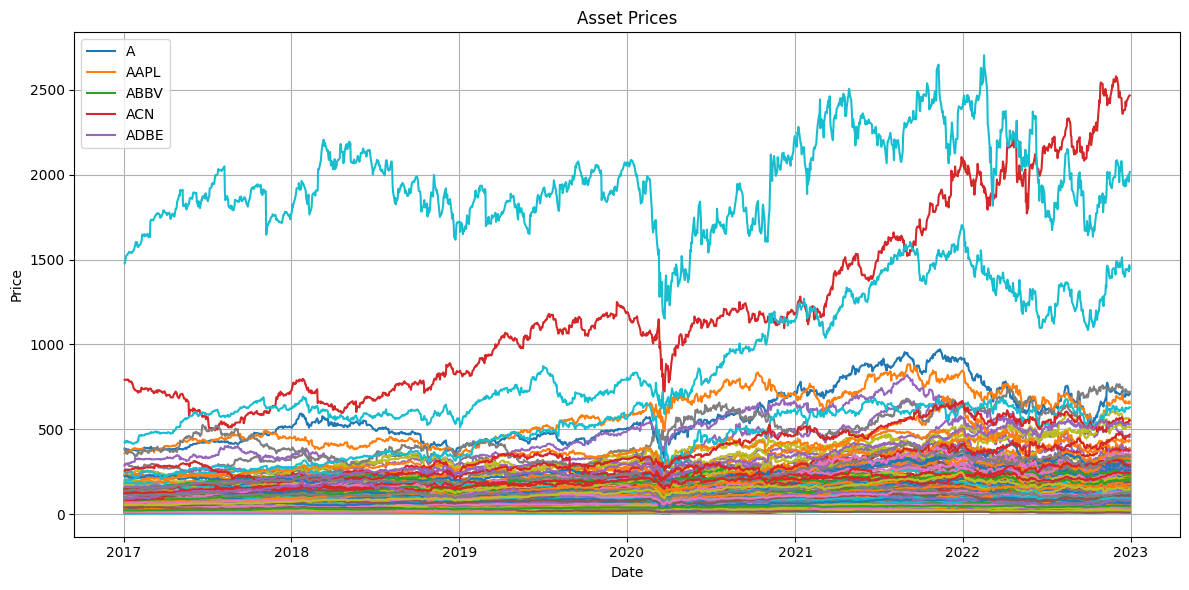

In [12]:
viz.plot_github(
    prices,
    title="Asset Prices",
    ylabel="Price"
)

## Use the graph below for better rendering

In [13]:
'''viz.plot_prices(prices)'''

'viz.plot_prices(prices)'

In [15]:
returns = ReturnCalculator.log_returns(prices)
correlation = returns.corr()
returns.head()  

,A,AAPL,ABBV,ACN,ADBE,ADI,ADP,ADSK,AEE,AES,...,WEC,WELL,WM,WMT,WTW,WYNN,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,0.013036,-0.001120,0.014002,0.002401,0.006358,-0.002071,0.001545,0.017437,0.001145,-0.008613,...,0.007664,0.007678,-0.002840,0.005809,0.012258,0.031734,0.014794,0.003632,0.009152,0.009657
2017-01-05,-0.011961,0.005072,0.007556,-0.015104,0.016854,-0.014477,-0.005999,-0.007640,0.004946,-0.013061,...,0.001356,0.022099,0.003832,0.002170,0.009572,0.012767,-0.009171,0.003305,0.006404,-0.003332
2017-01-06,0.030681,0.011087,0.000314,0.011328,0.022315,0.003918,0.000679,0.030342,0.007561,0.035303,...,-0.004075,0.004099,-0.005683,-0.013821,0.006489,0.010769,-0.007034,0.012025,0.000095,0.003147
2017-01-09,0.003121,0.009118,0.006562,-0.011241,0.002490,0.004737,-0.006226,0.003650,-0.021125,-0.024841,...,-0.013704,-0.000731,-0.005858,0.006571,-0.006092,0.003456,-0.004245,0.002790,0.019249,-0.002776
2017-01-10,-0.000831,0.001008,-0.002183,0.000522,-0.002859,0.005683,-0.002638,0.004888,-0.000385,-0.017498,...,0.002068,-0.030881,-0.004165,-0.007010,0.001665,0.022178,-0.004670,0.005865,0.060471,-0.000371


In [16]:
returns_sel = returns[:'2020-01-01']
returns_valid = returns['2020-01-02':]

### Github friendly graph, the other graphs use plotly which doesn't render on github

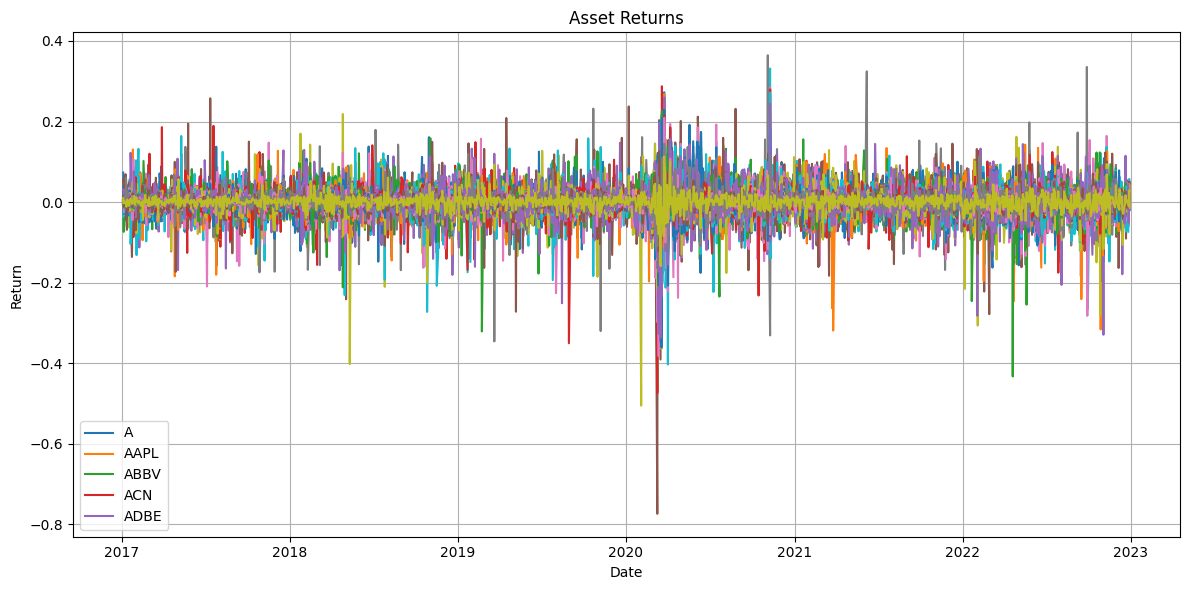

In [17]:
viz.plot_github(
    returns,
    title="Asset Returns",
    ylabel="Return"
)

## Use the graph below for better rendering

In [18]:
'''viz.plot_returns(returns)'''

'viz.plot_returns(returns)'

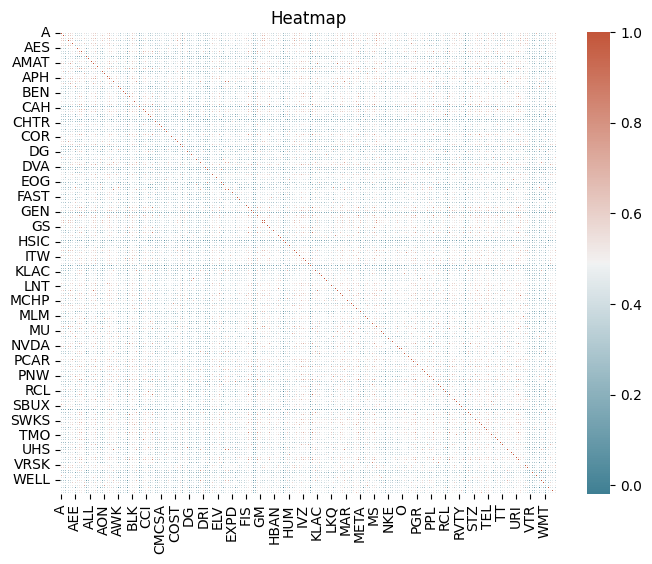

In [15]:
viz.heatmap(correlation)

In [16]:
valid = set(prices.columns)

sector_map = {
    sector: [t for t in tickers if t in valid]
    for sector, tickers in sector_map.items()
}

# 2. Pairs creation

We use both the distance approach and ML approach to find potential pairs and keep both

In [18]:
dist_selector = DistanceApproach(
    returns=returns_sel,
    sector_map=sector_map,
    sector_neutral=True
)

selected_pairs_dist = dist_selector.select(
    metric="angular",
    top_k=8
)

selected_pairs_dist

{'Communication Services': [('GOOGL', 'GOOG'),
  ('NWSA', 'NWS'),
  ('OMC', 'IPG'),
  ('META', 'GOOGL'),
  ('META', 'GOOG'),
  ('VZ', 'T'),
  ('CMCSA', 'CHTR'),
  ('NFLX', 'GOOG')],
 'Consumer Discretionary': [('LEN', 'DHI'),
  ('PHM', 'DHI'),
  ('PHM', 'LEN'),
  ('RCL', 'CCL'),
  ('TJX', 'ROST'),
  ('ORLY', 'AZO'),
  ('LOW', 'HD'),
  ('GM', 'APTV')],
 'Consumer Staples': [('DLTR', 'DG'),
  ('SJM', 'K'),
  ('MDLZ', 'K'),
  ('WMT', 'COST'),
  ('SJM', 'MDLZ'),
  ('WMT', 'DG'),
  ('MKC', 'MDLZ'),
  ('K', 'CAG')],
 'Energy': [('EOG', 'DVN'),
  ('VLO', 'MPC'),
  ('VLO', 'PSX'),
  ('DVN', 'APA'),
  ('PSX', 'MPC'),
  ('EOG', 'APA'),
  ('OKE', 'KMI'),
  ('OKE', 'DVN')],
 'Financials': [('V', 'MA'),
  ('KEY', 'HBAN'),
  ('RF', 'KEY'),
  ('RF', 'HBAN'),
  ('HBAN', 'CFG'),
  ('RF', 'CFG'),
  ('KEY', 'CFG'),
  ('RF', 'FITB')],
 'Health Care': [('UNH', 'ELV'),
  ('TMO', 'A'),
  ('TMO', 'RVTY'),
  ('MCK', 'COR'),
  ('RVTY', 'A'),
  ('TMO', 'DHR'),
  ('MCK', 'CAH'),
  ('RVTY', 'MTD')],
 'Industrials'

In [20]:
ml_selector = MLApproach(
    returns=returns_sel,
    n_components=3,
    n_clusters=5,
    random_state=0
)

selected_pairs_ml = ml_selector.select(top_k=5)
selected_pairs_ml

[('WEC', 'LNT'),
 ('UDR', 'AVB'),
 ('UDR', 'EQR'),
 ('EQR', 'AVB'),
 ('LNT', 'AEE'),
 ('NWSA', 'NWS'),
 ('VMC', 'MLM'),
 ('LEN', 'DHI'),
 ('EOG', 'DVN'),
 ('PHM', 'DHI'),
 ('TRV', 'CB'),
 ('WM', 'RSG'),
 ('MMC', 'AJG'),
 ('PAYX', 'ADP'),
 ('MMC', 'AON'),
 ('KEY', 'HBAN'),
 ('RF', 'KEY'),
 ('RF', 'HBAN'),
 ('HBAN', 'CFG'),
 ('RF', 'CFG'),
 ('GOOGL', 'GOOG'),
 ('V', 'MA'),
 ('LRCX', 'AMAT'),
 ('KLAC', 'AMAT'),
 ('LRCX', 'KLAC')]

In [21]:
returns_clean = returns_sel.dropna()
scaler = StandardScaler()
X = scaler.fit_transform(returns_clean.T)  

pca = PCA(n_components=3, random_state=42)
scores = pca.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(scores)

print("Unique clusters:", set(cluster_labels))
print("Counts:", {c: list(cluster_labels).count(c) for c in set(cluster_labels)})

Unique clusters: {0, 1, 2, 3, 4}
Counts: {0: 137, 1: 28, 2: 46, 3: 33, 4: 35}


In [22]:
viz.pca_scree(pca)

In [23]:
viz.pca_scatter(returns, cluster_labels=cluster_labels)

In [24]:
candidate_pairs = set()

# Distance approach
for sector, lst in selected_pairs_dist.items():
    for pair in lst:
        candidate_pairs.add(tuple(sorted(pair)))

# ML approach
for pair in selected_pairs_ml:
    candidate_pairs.add(tuple(sorted(pair)))

candidate_pairs = list(candidate_pairs)
len(candidate_pairs)

91

# 3. Pairs selection

We only keep the pairs that : <br>
- Pass the Engle Granger 2 step method (tests for Cointegration)
- Have a Hurst exponent lower than 0.45 (no long term memory)
- Are tradeable, meaning they have a half-life between 1 day and 60-90 days

In [26]:
checker = PairConfirmation(
    adf_threshold=0.05,
    hurst_max=0.45,
    hl_min=1,
    hl_max=60
)

confirmed = []
diagnostics = []

for (a, b) in candidate_pairs:
    if a not in prices_sel or b not in prices_sel:
        continue
        
    is_ok, diag = checker.confirm_pair(prices_sel[a], prices_sel[b])
    diag["pair"] = (a,b)
    diagnostics.append(diag)

    if is_ok:
        confirmed.append((a, b))

print("Final confirmed tradeable pairs:", confirmed)

Final confirmed tradeable pairs: [('HBAN', 'KEY'), ('MA', 'V'), ('ES', 'WEC'), ('NWS', 'NWSA'), ('EQR', 'ESS'), ('COR', 'MCK'), ('HBAN', 'RF'), ('GOOG', 'GOOGL')]


In [29]:
diag_df = pd.DataFrame(diagnostics)
diag_df.sort_values("adf_pvalue").head()

,hedge_ratio,adf_pvalue,eg_stationary,hurst,hurst_ok,half_life,half_life_ok,is_valid,pair
39,1.001399,0.000339,True,0.127568,True,7.514840,True,True,"(NWS, NWSA)"
55,0.538578,0.002297,True,0.168351,True,20.134030,True,True,"(HBAN, RF)"
19,1.846891,0.004980,True,0.191602,True,14.871753,True,True,"(MA, V)"
1,0.599752,0.014061,True,0.177407,True,47.098854,True,True,"(HBAN, KEY)"
43,0.811427,0.016743,True,0.212348,True,236.862726,False,False,"(DHI, LEN)"


# 4. Compute the spread for the selected pairs (Beta neutral or Dollar neutral)

In [30]:
builder_spread = SpreadConstructor(prices_valid, confirmed, method="beta")
spread_dict = builder_spread.build_all_spreads()

In [31]:
spread_dict_for_viz = {}
for pair, df in spread_dict.items():
    s = df["spread"]
    z = (s - s.mean()) / s.std()
    tmp = df.copy()
    tmp["Delta_norm"] = z
    spread_dict_for_viz[pair] = tmp

In [32]:
viz.plot_spread(spread_dict_for_viz)

# 5. Create the signals 

- Entry when the absolute value of the z-score of the spread reaches a certain level (2 stds)
- Exit when it goes below .5
- Hard cap stop loss to mitigate losses even though not ideal (4 stds)
- Time stop when the position is held for more than 3 half lives of the spread

In [33]:
half_lives = {}

for pair, df in spread_dict.items():
    hl = estimate_half_life(df["spread"])
    if hl > 0 and hl < 250: 
        half_lives[pair] = hl

In [34]:
signal_gen = SignalGenerator(
    entry_z=2.0,
    exit_z=0.5,
    stop_z=4.0,
    time_stop_k=3.0  
)

signals_dict = signal_gen.generate_signals_for_pairs(spread_dict, half_lives)


In [35]:
viz.plot_spread_with_signals(signals_dict)

# 6. Backtesting

{'total_return': 0.04923355119353201, 'annualized_return': 0.016412834141531718, 'annualized_vol': 0.02185077909018896, 'sharpe': 0.7511326746651844, 'max_drawdown': -0.03037176808078912}


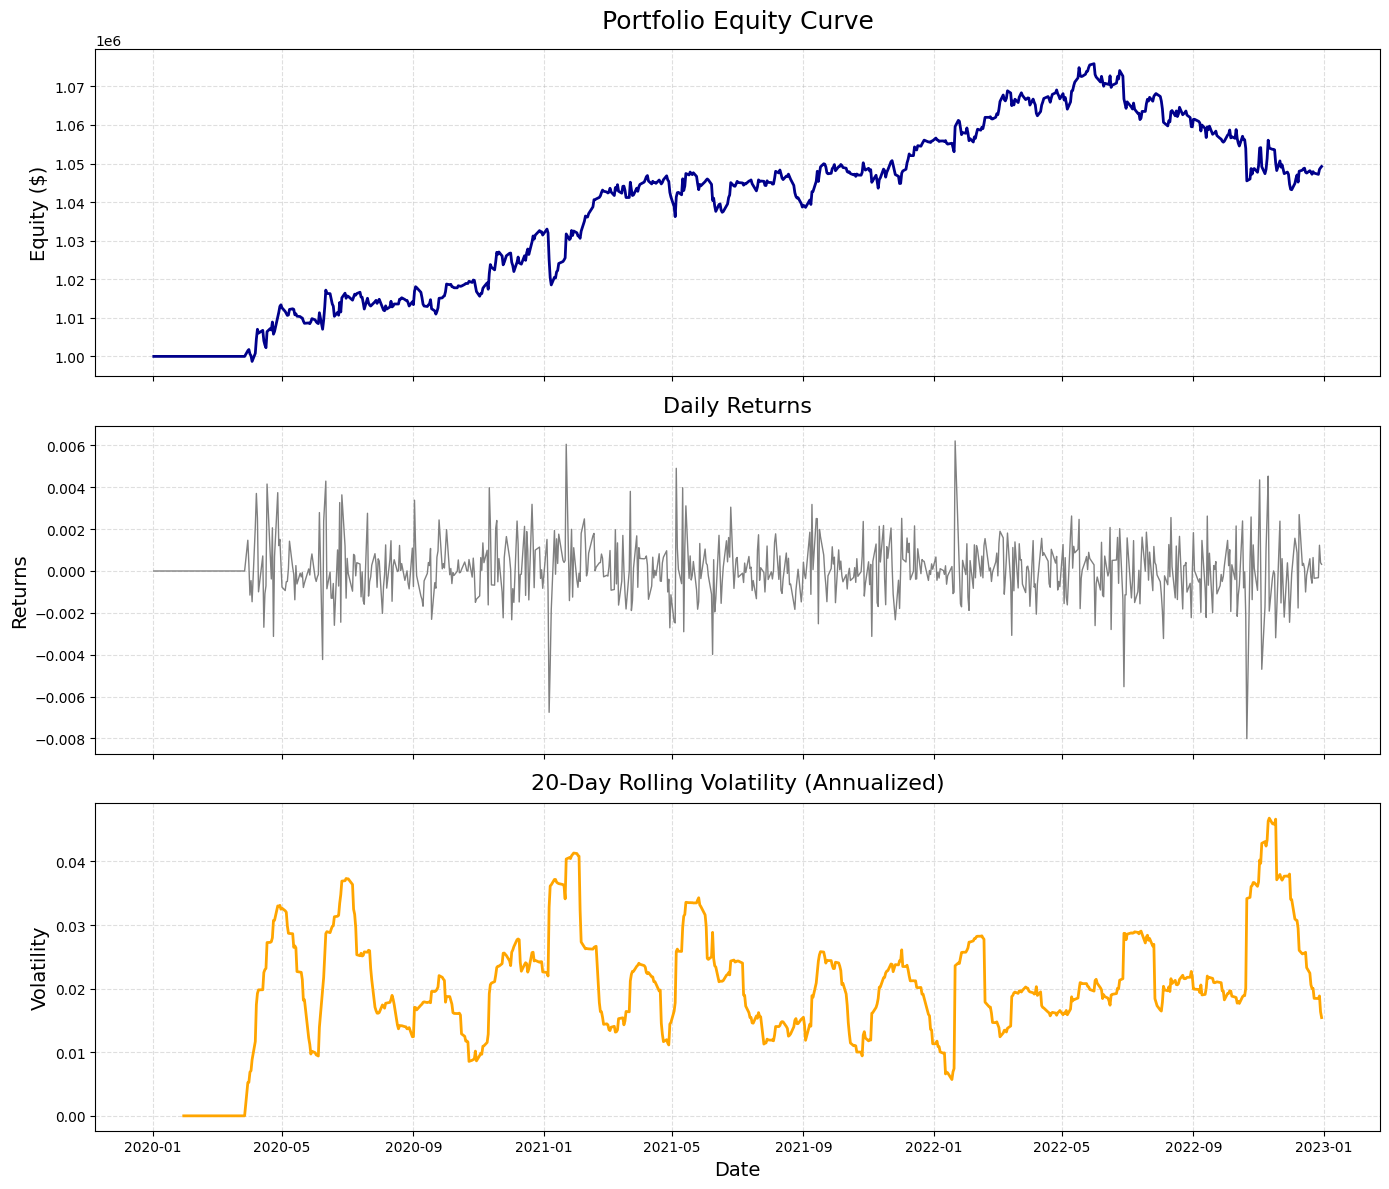

In [36]:
bt = PairBacktester(signals_dict, capital=1_000_000)

portfolio_df = bt.run()

stats = bt.summary()
print(stats)

plot_full_tearsheet(portfolio_df)

In [37]:
stats_table = stats_to_table(stats)
stats_table

,Value
total_return,4.92%
annualized_return,1.64%
annualized_vol,2.19%
sharpe,0.75
max_drawdown,-3.04%
